# Introduction to bayesian statistics
sources:
- https://www.youtube.com/watch?v=Pahyv9i_X2k
- https://towardsdatascience.com/frequentist-vs-bayesian-approaches-in-machine-learning-86ece21e820e
- https://machinelearningmastery.com/bayes-theorem-for-machine-learning/
- https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53

# Theory

## frequentist vs bayesian statistics

### frequentist statistics
- focuses on the parameter (which is assumed to be fixed constant)
- confidence intervals are read in terms of repeated sampling


- Eg. in logistic regression the data is assumed to be sampled from Bernoulli distribution, and in linear regression the data is assumed to be sampled from Gaussian distribution

- interpretation of interval: " 95% of similar sized intervals from repeated samples of size "n" will contain "θ" "

### bayesian statistics
- focuses on subjective parameter (takes into account a priori predictions)
- credible intervals read in terms of subjective uncertainty


- the assumptions include a prior distribution of the hypotheses P(θ), and a likelihood of data P(Data|θ)

- interpretation of interval: "There is a 95% chance that θ exists within the interval.. "

## Bayes theorem
Posterior = Likelihood * Prior / Evidence

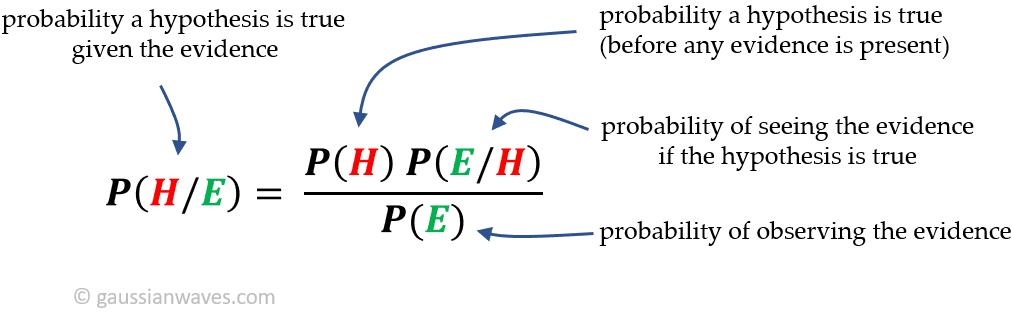

In [1]:
from IPython.display import Image
Image(filename="img/bayes-theorem.png", width=900)

### Review of probabilities
- Bayes Theorem provides a principled way for calculating a conditional probability

Probabilities:
- Marginal Probability: The probability of an event irrespective of the outcomes of other random variables, e.g. P(A)
- Joint Probability: Probability of two (or more) simultaneous events, e.g. P(A and B) or P(A, B)
- Conditional Probability: Probability of one (or more) event given the occurrence of another event, e.g. P(A given B) or P(A | B)

## Bayesian inference
- Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. Bayesian inference is an important technique in statistics, and especially in mathematical statistics.

## Conjugate priors
- For some likelihood functions, if you choose a certain prior, the posterior ends up being in the same distribution as the prior. Such a prior then is called a Conjugate Prior.

## Credible intervals
- In Bayesian statistics, a credible interval is an interval within which an unobserved parameter value falls with a particular probability. 

# Example with Pystan library
source: https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53

## imports libraries

In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()
np.random.seed(101)

In [2]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

## sets fixed values
- Here we will specify the ‘ground truth’ values of our parameters which we’ll aim to reproduce using Stan, and generate data from these parameters using numpy, making sure to add Gaussian noise
- underlying Markov process is stochastic

In [3]:
# Parameters to be inferred
alpha = 4.0 #intercept
beta = 0.5 #theta
sigma = 1.0 #standard deviation

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x

# scale is standard deviation (spread or “width”) of the distribution. Must be non-negative.
y = np.random.normal(y, scale=sigma)

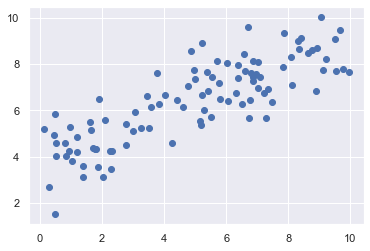

In [4]:
plt.scatter(x,y)

## runs model
- iter - total number of samples that will be generated from each Markov chain
- chains - the number of chains from which samples will be combined to form the posterior distribution
- warmup - the amount of samples that will be discarded from the beginning of each chain 
- thin - specifies an interval in sampling at which samples are retained

In [14]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}
# Compile the model
sm = pystan.StanModel(model_code=model)
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


In [6]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

In [25]:
fit

Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.86  6.2e-3   0.19   3.49   3.74   3.86   3.98   4.23    933    1.0
beta    0.52  1.1e-3   0.03   0.45    0.5   0.52   0.54   0.58    918    1.0
sigma   1.01  2.1e-3   0.07   0.88   0.96    1.0   1.05   1.17   1174    1.0
lp__  -50.62    0.04   1.19  -53.7 -51.18 -50.29 -49.74 -49.27    864    1.0

Samples were drawn using NUTS at Mon May 17 18:25:24 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [18]:
df.head()

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.858669,0.006191,0.189138,3.486092,3.740662,3.858573,3.983137,4.234029,933.326078,1.002649
beta,0.517341,0.001088,0.032958,0.450511,0.495527,0.518074,0.538285,0.581938,917.719679,1.003183
sigma,1.009846,0.002111,0.072336,0.883933,0.958887,1.003556,1.053809,1.172806,1174.273685,1.000097
lp__,-50.619795,0.040592,1.192931,-53.701725,-51.181387,-50.294451,-49.738077,-49.268743,863.655948,1.003543


## Plotting the posteriors

In [39]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    plt.rcParams["figure.figsize"] = (10,6)
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))
    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.gcf().tight_layout()
    plt.legend()

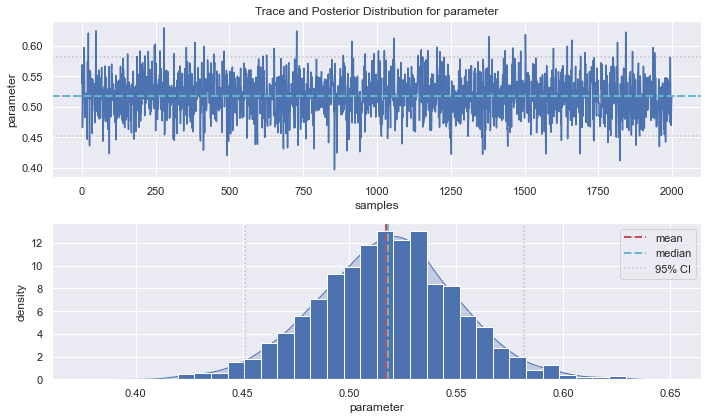

In [40]:
# beta
plot_trace(beta)

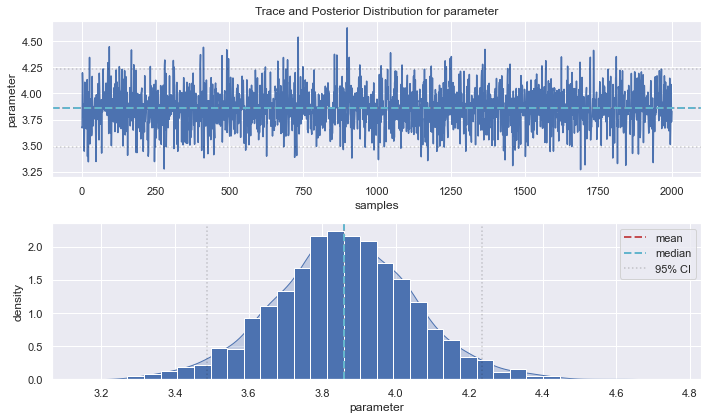

In [41]:
# alpha
plot_trace(alpha)

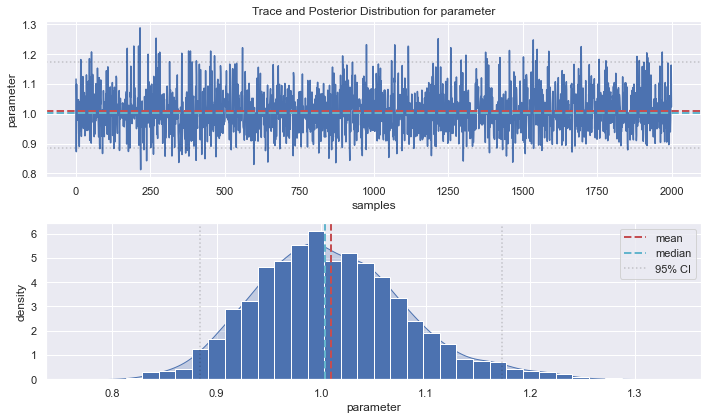

In [42]:
# sigma
plot_trace(sigma)

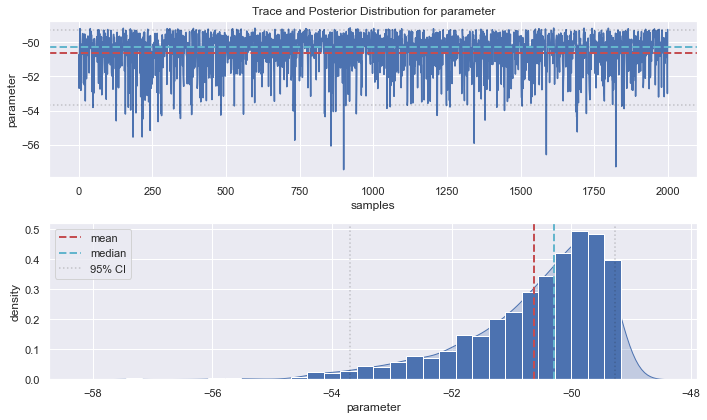

In [43]:
# lp
plot_trace(lp)